# Import

## Modules

In [72]:
%load_ext autoreload
%autoreload 2

#Science and Data
import pandas as pd
import numpy as np
# from pandas_profiling import ProfileReport
from sklearn.model_selection import StratifiedShuffleSplit, TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
from scipy.stats import randint, uniform

from skopt import BayesSearchCV

# Infrastructure
from pathlib import Path
import sys
import os

#Plotting Tools
import seaborn as sns
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Pandas
pd.set_option('display.max_rows', 100)

# Matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['ytick.labelleft'] = True
plt.rcParams.update({'font.size': 18})

In [3]:
PROJECT_ROOT = !git rev-parse --show-toplevel
PROJECT_ROOT = Path(PROJECT_ROOT[0])
PATH_NOTEBOOK = PROJECT_ROOT / "notebooks"
PATH_TIME_SERIES = PATH_NOTEBOOK / "classification.time_series.xgboost"

## Data

src: https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection

In [4]:
raw_data = pd.read_csv(PATH_TIME_SERIES / "data" / "raw" / "data1.csv")
raw_data = pd.concat([raw_data, pd.read_csv(PATH_TIME_SERIES / "data" / "raw" / "data2.csv"), pd.read_csv(PATH_TIME_SERIES / "data" / "raw" / "data3.csv")])

# Audit

## Data Types

In [5]:
raw_data.dtypes

date              object
Temperature      float64
Humidity         float64
Light            float64
CO2              float64
HumidityRatio    float64
Occupancy          int64
dtype: object

## Data Shape

In [6]:
raw_data.shape

(20560, 7)

## Duplicated Records

In [7]:
print(f"Number of duplicated records: {raw_data.duplicated().shape[0]}")

Number of duplicated records: 20560


# Data Cleaning and Feature Engineering

In [8]:
raw_data["date"] = pd.to_datetime(raw_data["date"])

# Exploratory Data Analysis

profile = ProfileReport(raw_data, title='Pandas Profiling Report', explorative=True)

profile.to_widgets()

# Time Series Plots

In [10]:
freq = "D"

In [11]:
plot_data = raw_data.set_index("date").resample(freq).mean().reset_index()

## Prior Probability

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Daily Plot of Prior Probability of Occupancy')

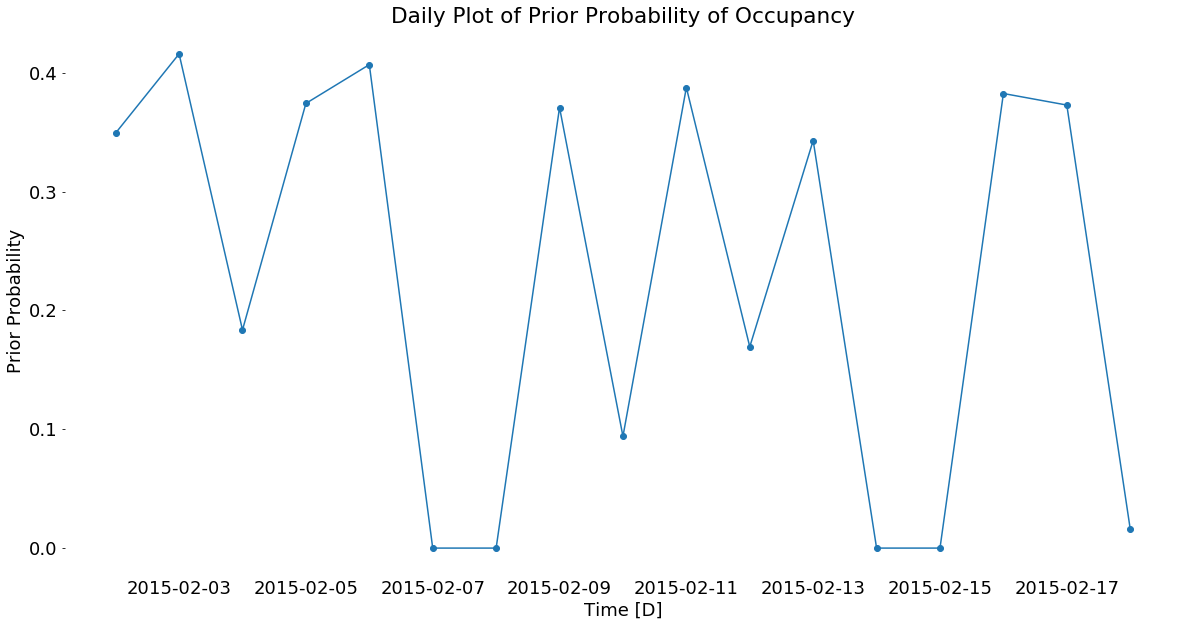

In [12]:
fig, ax = plt.subplots()
ax.plot(plot_data["date"], plot_data["Occupancy"], "o-")
ax.set_xlabel(f"Time [{freq}]")
ax.set_ylabel("Prior Probability")
ax.set_title("Daily Plot of Prior Probability of Occupancy")

## Temperature

Text(0.5, 1.0, 'Daily Plot of Average Temperature')

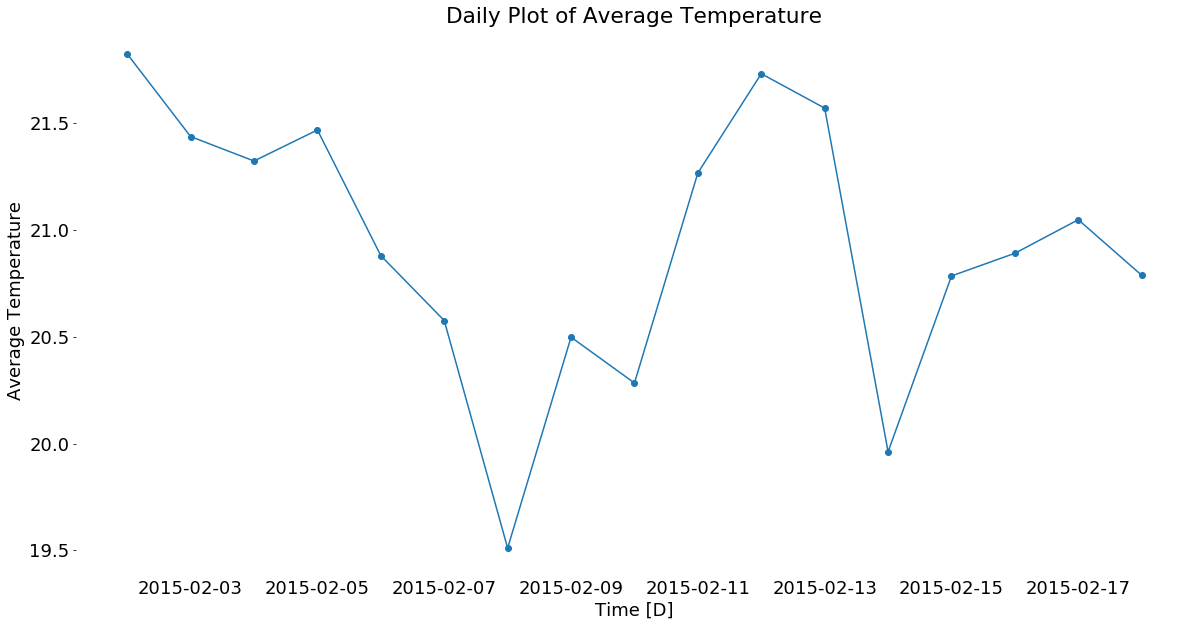

In [13]:
feature = "Temperature"
fig, ax = plt.subplots()
ax.plot(plot_data["date"], plot_data[feature], "o-")
ax.set_xlabel(f"Time [{freq}]")
ax.set_ylabel(f"Average {feature}")
ax.set_title(f"Daily Plot of Average {feature}")

## Light

Text(0.5, 1.0, 'Daily Plot of Average Light')

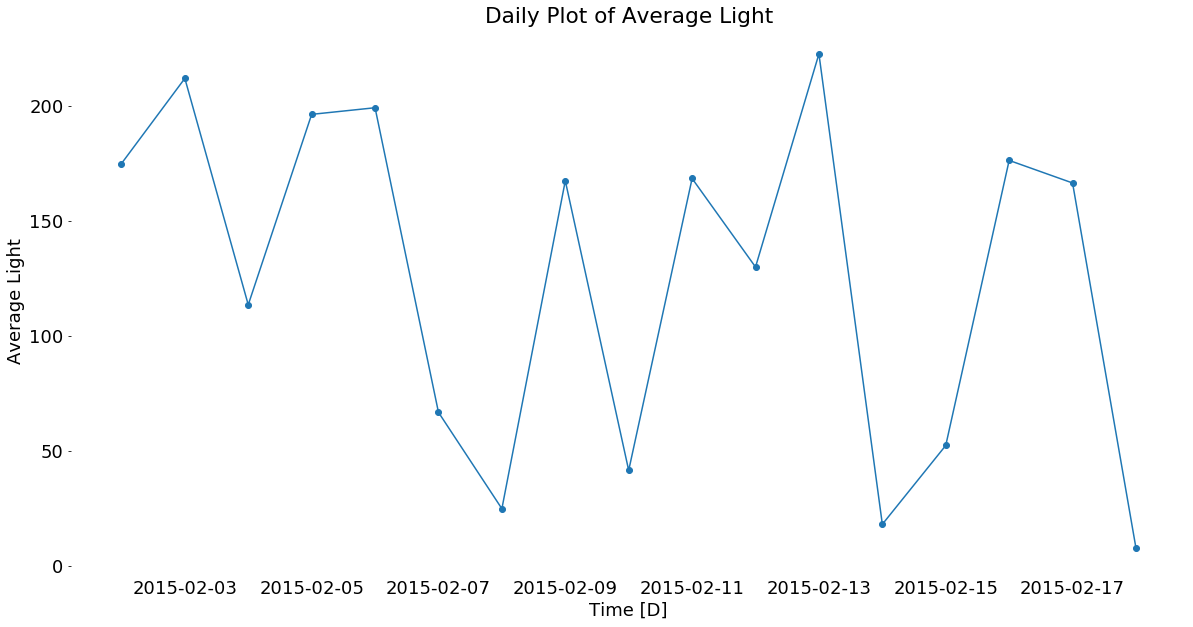

In [14]:
feature = "Light"
fig, ax = plt.subplots()
ax.plot(plot_data["date"], plot_data[feature], "o-")
ax.set_xlabel(f"Time [{freq}]")
ax.set_ylabel(f"Average {feature}")
ax.set_title(f"Daily Plot of Average {feature}")

## CO2

Text(0.5, 1.0, 'Daily Plot of Average CO2')

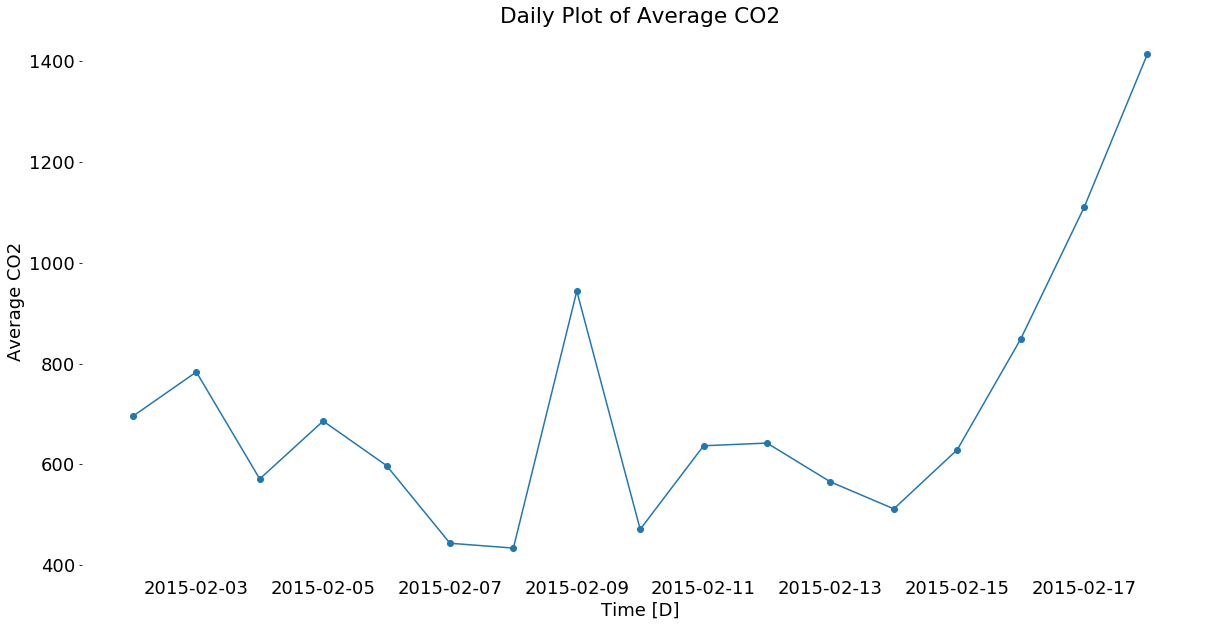

In [15]:
feature = "CO2"
fig, ax = plt.subplots()
ax.plot(plot_data["date"], plot_data[feature], "o-")
ax.set_xlabel(f"Time [{freq}]")
ax.set_ylabel(f"Average {feature}")
ax.set_title(f"Daily Plot of Average {feature}")

## Humidity Ratio

Text(0.5, 1.0, 'Daily Plot of Average HumidityRatio')

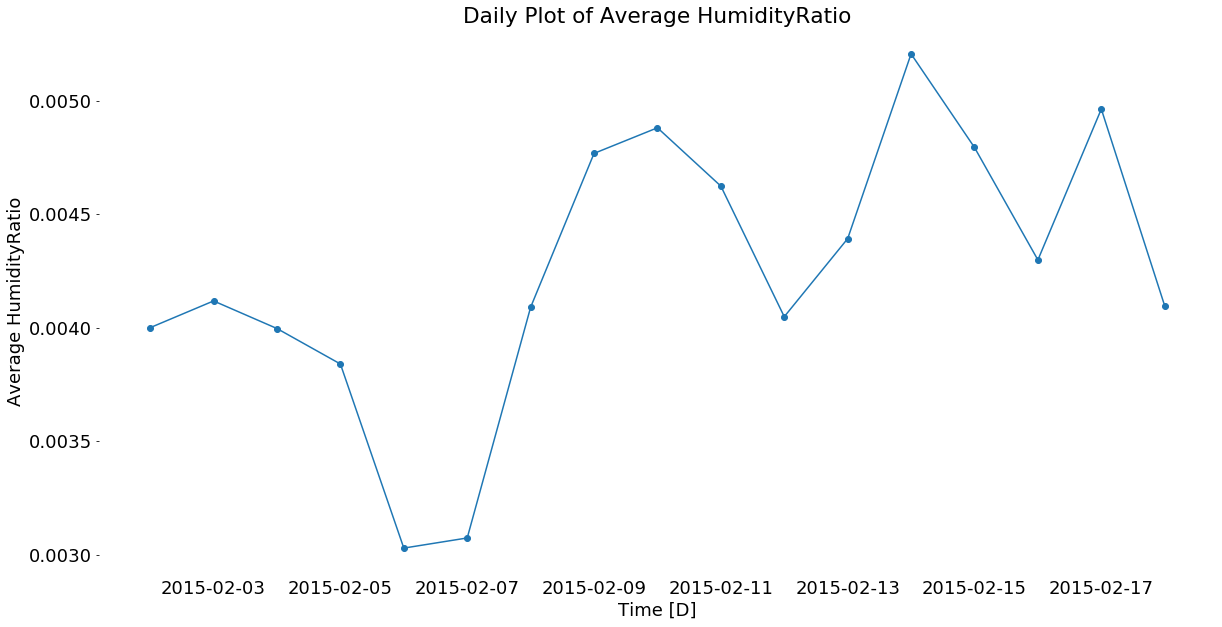

In [16]:
feature = "HumidityRatio"
fig, ax = plt.subplots()
ax.plot(plot_data["date"], plot_data[feature], "o-")
ax.set_xlabel(f"Time [{freq}]")
ax.set_ylabel(f"Average {feature}")
ax.set_title(f"Daily Plot of Average {feature}")

# Model

## Data Preparation

In [11]:
df = raw_data

In [12]:
y = df[["Occupancy"]]
X = df.drop(columns="Occupancy")

### Train Test Split

In [13]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_is, X_os = X.iloc[train_index], X.iloc[test_index]
    y_is, y_os = y.iloc[train_index], y.iloc[test_index]

### Time Split

In [14]:
split_date = "2015-02-13"

In [15]:
mask_is = X_is["date"] <= split_date
mask_os = X_os["date"] <= split_date

X_tv, y_tv = X_is[mask_is], y_is[mask_is]
X_is_ot, y_is_ot = X_is[~mask_is], y_is[~mask_is]
X_os_it, y_os_it = X_os[mask_os], y_os[mask_os]
X_os_ot, y_os_ot = X_os[~mask_os], y_os[~mask_os]

datasets_dict = {"train_validation": {"X": X_tv, "y": y_tv}
                ,"in-sample-out-of-time": {"X": X_is_ot, "y": y_is_ot}
                ,"out-of-sample-in-time": {"X": X_os_it, "y": y_os_it}
                ,"out-of-sample-out-of-time": {"X": X_os_ot, "y": y_os_ot}
                }

del X_is_ot, y_is_ot, X_os_it, y_os_it, X_os_ot, y_os_ot

In [16]:
for dataset_type in datasets_dict.values():
    dataset_type["X"].reset_index(inplace=True, drop=True)
    dataset_type["y"].reset_index(inplace=True, drop=True)

## Prepare Estimator

In [17]:
estimator = RandomForestClassifier()

In [18]:
estimator = XGBClassifier()

## Prepare Cross Validation

src: https://hub.packtpub.com/cross-validation-strategies-for-time-series-forecasting-tutorial/

In [47]:
X_tv.sort_values(by="date", inplace=True)

tscv = TimeSeriesSplit(n_splits=5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [48]:
distributions = {"n_estimators": randint(10, 1000)
                ,"max_depth": randint(1, 10)
                ,"min_samples_split": uniform(loc=0, scale=1)
                ,"oob_score": [True]
                ,"criterion": ["gini", "entropy"]}

In [57]:
distributions = {"n_estimators": randint(100, 10000)
                ,"max_depth": randint(1, 3)
                ,"learning_rate": uniform(loc=0, scale=1)
                ,"gamma": uniform(loc=0, scale=1)
                ,"min_child_weight": uniform(loc=0, scale=1)
                ,"reg_alpha": uniform(loc=0, scale=1)
                ,"reg_lambda": uniform(loc=0, scale=1)
                ,"scale_pos_weight": uniform(loc=0, scale=1)
                ,"booster": ["gbtree", "gblinear", "dart"]}

In [65]:
clf = RandomizedSearchCV(estimator, distributions, cv=tscv, n_jobs=-1, n_iter=20)
search = clf.fit(X_tv.set_index("date"), y_tv)
search.best_params_

[18:04:47] WARNING: ../src/learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, interaction_constraints, max_delta_step, max_depth, min_child_weight, monotone_constraints, num_parallel_tree, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'booster': 'gblinear',
 'gamma': 0.0809973061027024,
 'learning_rate': 0.5716354483887944,
 'max_depth': 6,
 'min_child_weight': 0.8213885407075893,
 'n_estimators': 945,
 'reg_alpha': 0.5836659317732996,
 'reg_lambda': 0.17120061329466896,
 'scale_pos_weight': 0.983230558615956}

In [113]:
from skopt.space import Real, Categorical, Integer
bayes_distributions = {"n_estimators": Integer(10, 1000, prior="uniform")
                ,"max_depth": Integer(1, 10, prior="uniform")
                ,"learning_rate": Real(0, 1, prior="log-uniform")
                ,"gamma": Real(0, 1, prior="log-uniform")
                ,"min_child_weight": Real(0, 1, prior="log-uniform")
                ,"reg_alpha": Real(0, 1, prior="log-uniform")
                ,"reg_lambda": Real(0, 1, prior="log-uniform")
                ,"scale_pos_weight": (0, 1, "uniform")
                ,"booster": Categorical(["gbtree", "gblinear", "dart"])}

In [114]:
clf = BayesSearchCV(estimator, bayes_distributions, cv=tscv, n_jobs=-1, n_iter=5)
search = clf.fit(X_tv.set_index("date"), y_tv)
search.best_params_

ValueError: Not all points are within the bounds of the space.

In [ ]:
pd.DataFrame.from_dict(clf.cv_results_).sort_values(by="rank_test_score")

In [ ]:
estimator = clf.best_estimator_

# Test Model

In [101]:
performance_metrics = {"date": []
                      ,"dataset_type": []
                       ,"f1_score": []
                       ,"roc_auc_score": []
                       ,"recall_score": []
                       ,"precision_score": []
                       ,"support": []
                       ,"prior_proba": []}

In [102]:
for test_type, datasets in datasets_dict.items():
    X = datasets["X"]
    y = datasets["y"]
    print(test_type)
    for day in X['date'].dt.day.unique():
        mask = X['date'].dt.day == day
        performance_metrics["date"].append(X.loc[mask, 'date'].dt.date.unique()[0])
        y_hat_proba = estimator.predict_proba(X[mask].set_index("date"))[:, 1]
        y_hat = estimator.predict(X[mask].set_index("date"))
        assert X[mask].shape[0] <= y.shape[0] 
        try:
            performance_metrics["roc_auc_score"].append(roc_auc_score(y.values.squeeze()[X[mask].index.values], y_hat_proba))

        except ValueError:
            performance_metrics["roc_auc_score"].append(np.nan)

        performance_metrics["f1_score"].append(f1_score(y.values.squeeze()[X[mask].index.values], y_hat))
        performance_metrics["recall_score"].append(recall_score(y.values.squeeze()[X[mask].index.values], y_hat))
        performance_metrics["precision_score"].append(precision_score(y.values.squeeze()[X[mask].index.values], y_hat))
        performance_metrics["dataset_type"].append(test_type)
        performance_metrics["support"].append(y.values.squeeze()[X[mask].index.values].shape[0])
        performance_metrics["prior_proba"].append(np.mean(y.values.squeeze()[X[mask].index.values]))

train_validation
in-sample-out-of-time


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F

out-of-sample-in-time
out-of-sample-out-of-time


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-de

In [103]:
performance_metrics_df = pd.DataFrame.from_dict(performance_metrics)
performance_metrics_df.sort_values(by="date", inplace=True)

## Plots

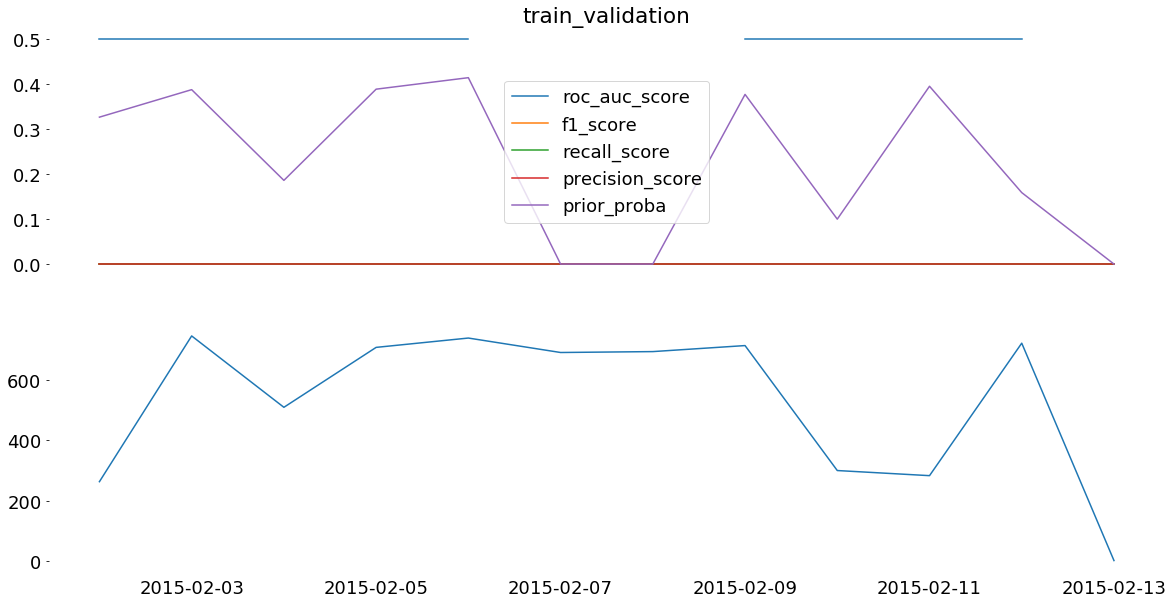

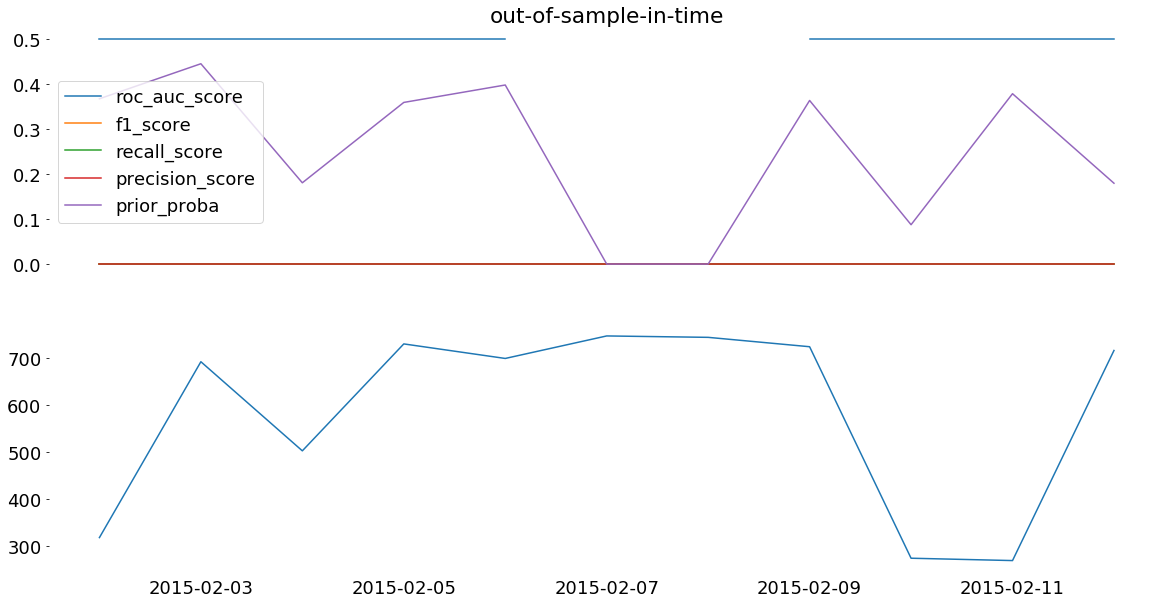

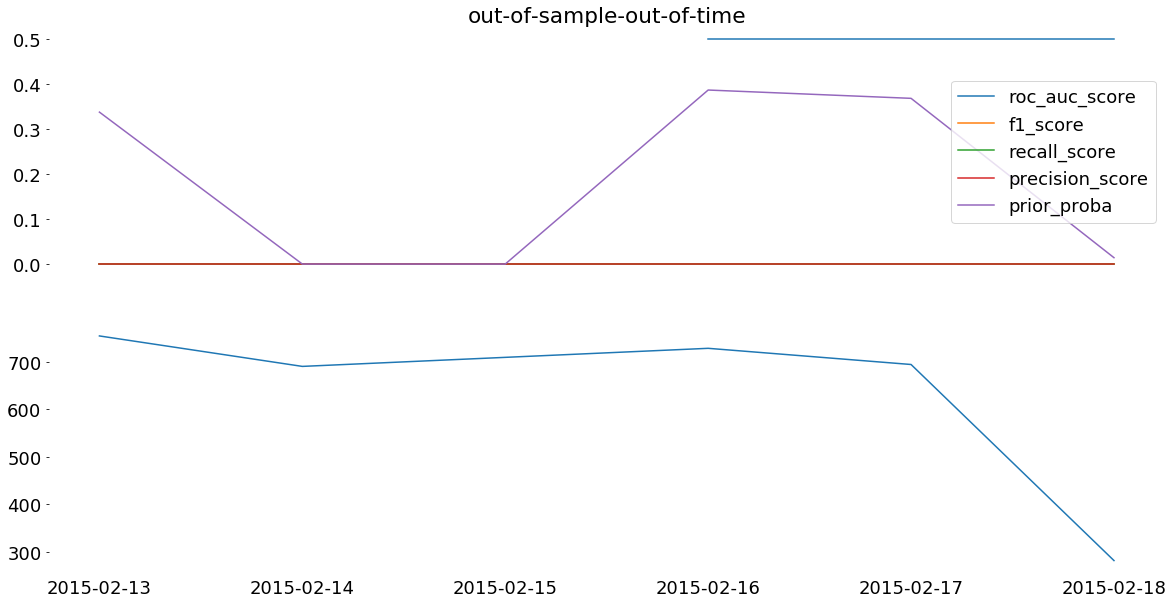

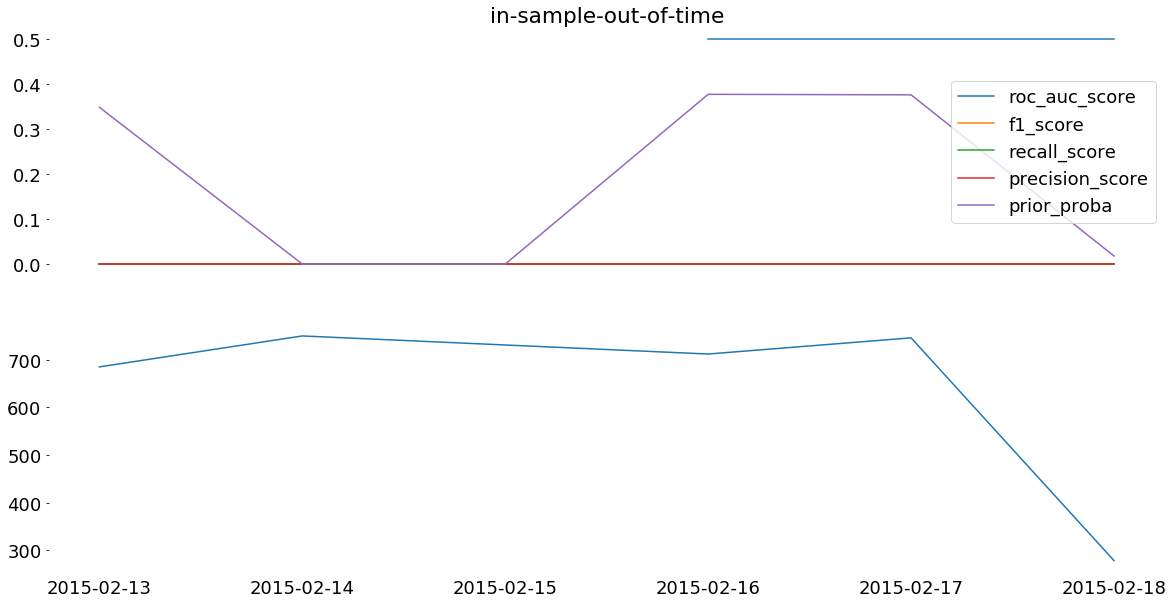

In [104]:
from itertools import product
for dataset_type in performance_metrics_df["dataset_type"].unique():
    fig, (pm, sup) = plt.subplots(nrows=2, sharex=True)
    for performance_metric in ["roc_auc_score", "f1_score", "recall_score", "precision_score", "prior_proba"]:
        mask = performance_metrics_df["dataset_type"] == dataset_type
        pm.plot(performance_metrics_df.loc[mask, "date"], performance_metrics_df.loc[mask, performance_metric], label=performance_metric)
    sup.plot(performance_metrics_df.loc[mask, "date"], performance_metrics_df.loc[mask, "support"], label="support")
    
    pm.set_title(f"{dataset_type}")
    pm.legend()

# References

* https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

* https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/